In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"soniakashyap","key":"8ddbd14e6c9790dac9275cb551f7f330"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rahulm7323/damaged-and-intact-packages")

print("Path to dataset files:", path)

100%|██████████| 51.0M/51.0M [00:03<00:00, 15.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rahulm7323/damaged-and-intact-packages/versions/1


In [ ]:
import os

base_dir = "/root/.cache/kagglehub/datasets/rahulm7323/damaged-and-intact-packages/versions/1"

# List all files and folders in the dataset
for root, dirs, files in os.walk(base_dir):
    print(f"\n📂 {root}")
    for d in dirs:
        print("  ┗📁", d)
    for f in files[:5]:  # just show a few files
        print("  ┗📄", f)



📂 /root/.cache/kagglehub/datasets/rahulm7323/damaged-and-intact-packages/versions/1
  ┗📁 damaged-and-intact-packages

📂 /root/.cache/kagglehub/datasets/rahulm7323/damaged-and-intact-packages/versions/1/damaged-and-intact-packages
  ┗📁 intact
  ┗📁 damaged

📂 /root/.cache/kagglehub/datasets/rahulm7323/damaged-and-intact-packages/versions/1/damaged-and-intact-packages/intact
  ┗📄 packagingboxes111.jpeg
  ┗📄 medicinepackagingboxes239.png
  ┗📄 medicinepackagingboxes263.jpeg
  ┗📄 fooditemboxes86.jpeg
  ┗📄 medicinepackagingboxes294.jpeg

📂 /root/.cache/kagglehub/datasets/rahulm7323/damaged-and-intact-packages/versions/1/damaged-and-intact-packages/damaged
  ┗📄 packagingboxesthataredamaged213.jpeg
  ┗📄 packagingboxesthataredamaged269.jpeg
  ┗📄 packagingboxesthataredamaged38.jpeg
  ┗📄 packagingboxesthataredamaged84.jpeg
  ┗📄 packagingboxesthataredamaged39.png


In [ ]:
base_dir = "/root/.cache/kagglehub/datasets/rahulm7323/damaged-and-intact-packages/versions/1/damaged-and-intact-packages"
damaged_dir = os.path.join(base_dir, "damaged")
intact_dir = os.path.join(base_dir, "intact")

print("Damaged images:", len(os.listdir(damaged_dir)))
print("Intact images:", len(os.listdir(intact_dir)))


Damaged images: 286
Intact images: 342


In [ ]:
import shutil

# Create structure for training
new_base = "/content/package_data"
for split in ["train", "val"]:
    for label in ["damaged", "intact"]:
        os.makedirs(f"{new_base}/{split}/{label}", exist_ok=True)

# Simple 80/20 train-val split
def copy_files(src_dir, dst_train, dst_val, split_ratio=0.8):
    files = os.listdir(src_dir)
    split = int(len(files) * split_ratio)
    for i, file in enumerate(files):
        dest = dst_train if i < split else dst_val
        shutil.copy(os.path.join(src_dir, file), os.path.join(dest, file))

copy_files(damaged_dir, f"{new_base}/train/damaged", f"{new_base}/val/damaged")
copy_files(intact_dir, f"{new_base}/train/intact", f"{new_base}/val/intact")



In [41]:
import random
import pandas as pd

# Define sample product categories
categories = ["Electronics", "Clothing", "Home", "Toys", "Books", "Beauty", "Sports"]

# Function to build image-category-label mapping
def build_metadata(image_dir, label):
    records = []
    for fname in os.listdir(image_dir):
        category = random.choice(categories)
        path = os.path.join(image_dir, fname)
        records.append({
            "image_id": fname,
            "label": label,
            "category": category,
            "filepath": path
        })
    return records

# Generate metadata from both train and val splits
metadata = []
for split in ["train", "val"]:
    for label in ["damaged", "intact"]:
        dir_path = os.path.join(new_base, split, label)
        metadata.extend(build_metadata(dir_path, label))

# Create dataframe
df = pd.DataFrame(metadata)

# Preview
print(df.head())

# Optional: Save to CSV for use in report or further analysis
df.to_csv("/content/package_metadata.csv", index=False)


                               image_id    label     category  \
0  packagingboxesthataredamaged213.jpeg  damaged  Electronics   
1  packagingboxesthataredamaged269.jpeg  damaged       Beauty   
2   packagingboxesthataredamaged38.jpeg  damaged         Home   
3   packagingboxesthataredamaged84.jpeg  damaged       Sports   
4    packagingboxesthataredamaged39.png  damaged  Electronics   

                                            filepath  
0  /content/package_data/train/damaged/packagingb...  
1  /content/package_data/train/damaged/packagingb...  
2  /content/package_data/train/damaged/packagingb...  
3  /content/package_data/train/damaged/packagingb...  
4  /content/package_data/train/damaged/packagingb...  


Damaged product count by category:
 category
Toys           46
Clothing       45
Home           45
Books          44
Electronics    42
Sports         35
Beauty         29
Name: count, dtype: int64


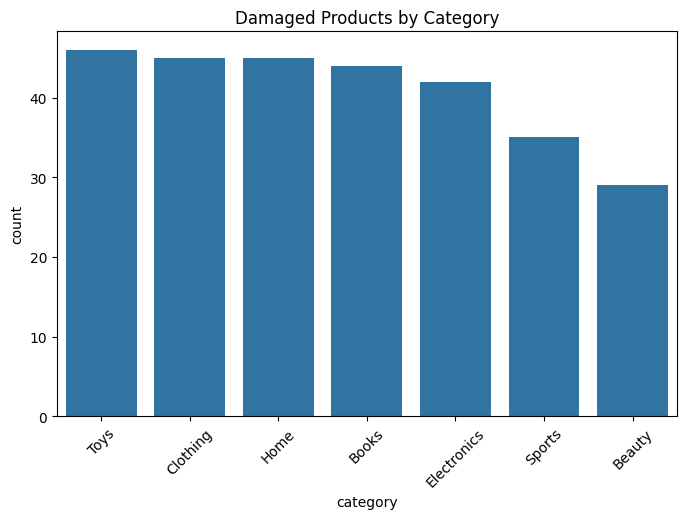

In [44]:
# Count damaged instances per category
damage_by_category = df[df["label"] == "damaged"]["category"].value_counts()
print("Damaged product count by category:\n", damage_by_category)

# Optional: Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.countplot(data=df[df["label"] == "damaged"], x="category", order=damage_by_category.index)
plt.title("Damaged Products by Category")
plt.xticks(rotation=45)
plt.show()


<ipython-input-43-4daf31aa4d01>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_counts.reset_index(), x='category', y='damage_rate', palette='Reds_r')


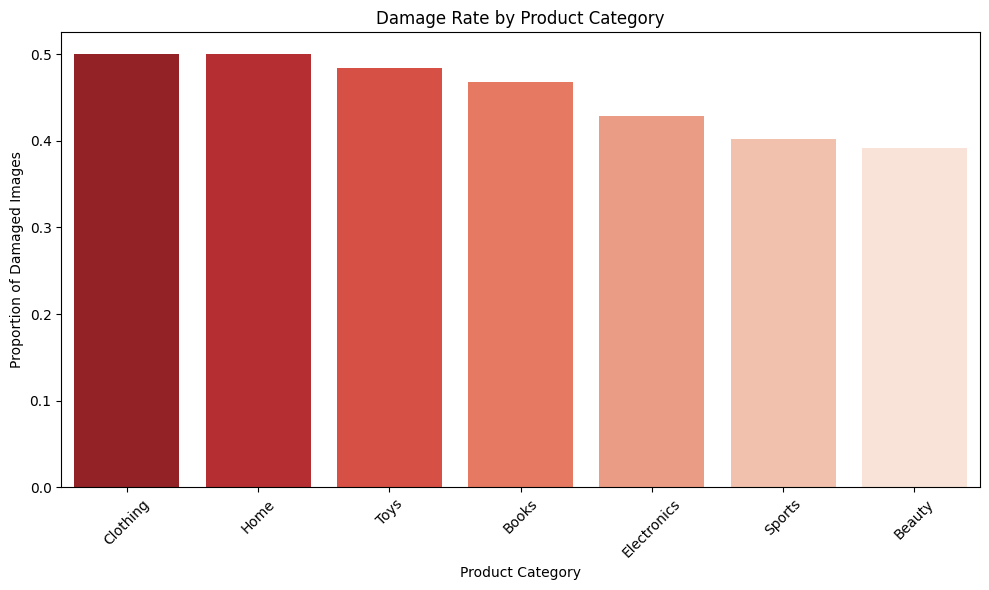

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the updated metadata
df = pd.read_csv("/content/package_metadata.csv")

# Count damaged vs intact by category
category_counts = df.groupby(['category', 'label']).size().unstack().fillna(0)

# Plot damage rates
category_counts['damage_rate'] = category_counts['damaged'] / (category_counts['damaged'] + category_counts['intact'])

# Sort by most damage-prone
category_counts = category_counts.sort_values(by='damage_rate', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=category_counts.reset_index(), x='category', y='damage_rate', palette='Reds_r')
plt.title("Damage Rate by Product Category")
plt.ylabel("Proportion of Damaged Images")
plt.xlabel("Product Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping

# ✅ Step 1: Load Updated Metadata
df = pd.read_csv("/content/package_metadata.csv")
df['label'] = df['label'].astype(str)


In [45]:
df.head()

,image_id,label,category,filepath
0,packagingboxesthataredamaged213.jpeg,damaged,Electronics,/content/package_data/train/damaged/packagingb...
1,packagingboxesthataredamaged269.jpeg,damaged,Beauty,/content/package_data/train/damaged/packagingb...
2,packagingboxesthataredamaged38.jpeg,damaged,Home,/content/package_data/train/damaged/packagingb...
3,packagingboxesthataredamaged84.jpeg,damaged,Sports,/content/package_data/train/damaged/packagingb...
4,packagingboxesthataredamaged39.png,damaged,Electronics,/content/package_data/train/damaged/packagingb...


In [46]:


# ✅ Step 2: Image Generators
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    df[df['filepath'].str.contains("/train/")],
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),
    class_mode="binary",
    batch_size=32,
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    df[df['filepath'].str.contains("/val/")],
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),
    class_mode="binary",
    batch_size=32,
    shuffle=False
)



Found 464 validated image filenames belonging to 2 classes.
Found 118 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 37 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 9 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
# ✅ Step 3: Build Model
base_model = MobileNetV2(input_shape=(224,224,3), include_top=False, weights="imagenet")
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:

# ✅ Step 4: Train Model
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop]
)




/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 2/15 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5234 - loss: 0.7250 

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.7047 - loss: 0.5349 - val_accuracy: 0.8220 - val_loss: 0.4394
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9123 - loss: 0.2424 - val_accuracy: 0.8390 - val_loss: 0.4373
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9553 - loss: 0.1533 - val_accuracy: 0.8305 - val_loss: 0.4607
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9793 - loss: 0.1100 - val_accuracy: 0.8475 - val_loss: 0.4439
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9771 - loss: 0.0800 - val_accuracy: 0.8390 - val_loss: 0.4582


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
✅ Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83        56
           1       0.86      0.82      0.84        62

    accuracy                           0.84       118
   macro avg       0.84      0.84      0.84       118
weighted avg       0.84      0.84      0.84       118



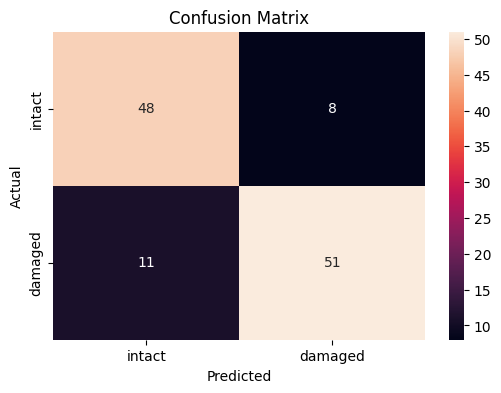

In [ ]:
# ✅ Step 5: Evaluation
val_gen.reset()
preds = model.predict(val_gen)
pred_labels = (preds > 0.5).astype(int)

print("✅ Classification Report:")
print(classification_report(val_gen.classes, pred_labels))

# Confusion Matrix
cm = confusion_matrix(val_gen.classes, pred_labels)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["intact", "damaged"], yticklabels=["intact", "damaged"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [47]:
loss, acc = model.evaluate(val_gen)
print(f"✅ Validation Accuracy: {acc*100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6193 - loss: 0.6514
✅ Validation Accuracy: 55.08%


In [48]:
# Get the number of samples actually predicted
num_samples = val_gen.samples

# Trim the dataframe to match predictions
val_df_trimmed = val_df.iloc[:num_samples].copy()

results_df = pd.DataFrame({
    "image_id": val_df_trimmed["filepath"].apply(os.path.basename),
    "label": val_df_trimmed["label"],
    "score": predictions.flatten(),
    "category": val_df_trimmed["category"]
})

results_df.to_csv("/content/final_model_predictions.csv", index=False)
print("✅ Saved: final_model_predictions.csv")


✅ Saved: final_model_predictions.csv


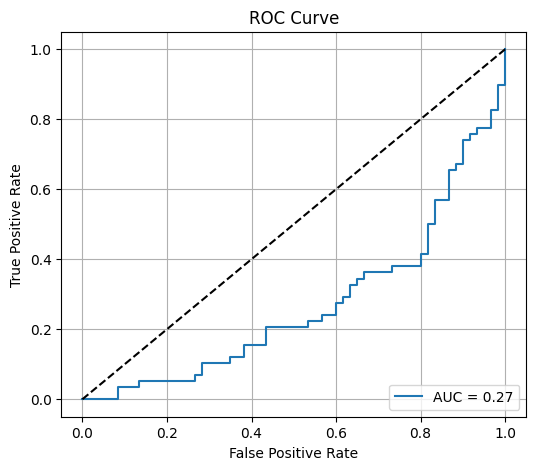

In [49]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# True labels and predicted scores
y_true = results_df["label"].map({"intact": 0, "damaged": 1})
y_scores = results_df["score"]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [50]:
# Define threshold (you can adjust based on business use-case)
threshold = 0.5
results_df["predicted_label"] = results_df["score"].apply(lambda x: "damaged" if x >= threshold else "intact")

# Category-wise analysis
category_damage_counts = results_df.groupby("category")["predicted_label"].value_counts().unstack().fillna(0)

# Calculate percentage of damaged predictions per category
category_damage_counts["damage_rate"] = category_damage_counts["damaged"] / (category_damage_counts["damaged"] + category_damage_counts["intact"]) * 100

# Display
print(category_damage_counts.sort_values("damage_rate", ascending=False))


predicted_label  damaged  intact  damage_rate
category                                     
Sports                10      10    50.000000
Beauty                 8       9    47.058824
Electronics            6       7    46.153846
Books                  8      10    44.444444
Clothing               6       8    42.857143
Toys                   6      12    33.333333
Home                   5      13    27.777778


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


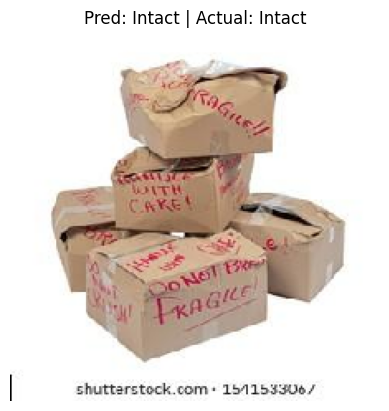

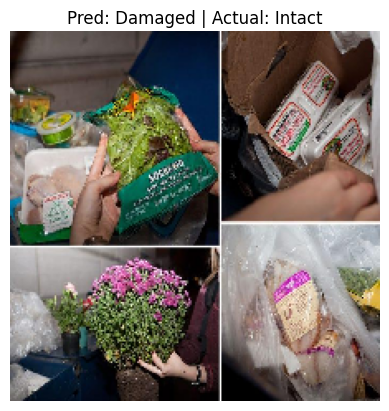

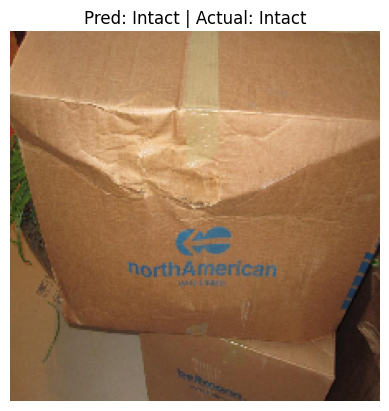

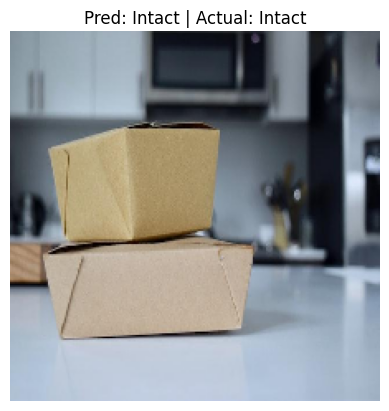

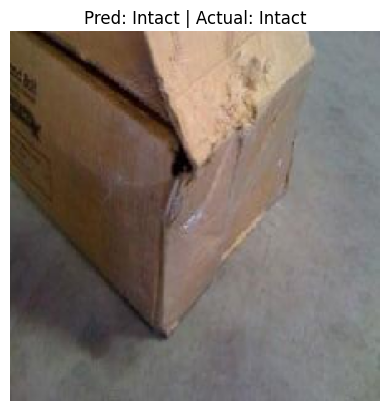

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images
images, labels = next(val_gen)
preds = model.predict(images)

# Display 5 predictions
for i in range(5):
    plt.imshow(images[i])
    pred_label = "Damaged" if preds[i] > 0.5 else "Intact"
    true_label = "Damaged" if labels[i] == 1 else "Intact"
    plt.title(f"Pred: {pred_label} | Actual: {true_label}")
    plt.axis('off')
    plt.show()


In [37]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense

# Functional API
input_tensor = Input(shape=(224, 224, 3))
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Note: Conv_1 is the last conv layer of MobileNetV2
last_conv_layer_name = 'Conv_1'

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_tensor, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


<ipython-input-37-38582186192e>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)


In [38]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(img_array, axis=0))
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_625']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


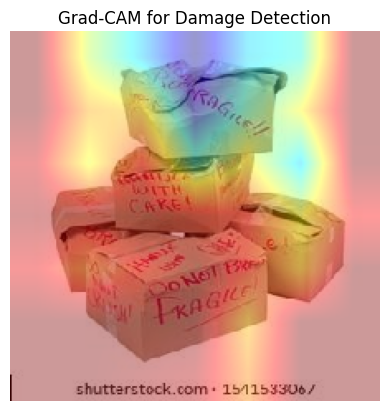

In [39]:
import cv2
import matplotlib.pyplot as plt

# Get a sample image
sample_img = images[0]  # Must be (224, 224, 3), rescaled

# Create heatmap
heatmap = make_gradcam_heatmap(sample_img, model, last_conv_layer_name)

# Superimpose heatmap
img_uint8 = (sample_img * 255).astype("uint8")
heatmap_resized = cv2.resize(heatmap, (img_uint8.shape[1], img_uint8.shape[0]))
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_uint8, 0.6, heatmap_color, 0.4, 0)

# Show
plt.imshow(superimposed_img)
plt.title("Grad-CAM for Damage Detection")
plt.axis('off')
plt.show()


<ipython-input-42-4daf31aa4d01>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_counts.reset_index(), x='category', y='damage_rate', palette='Reds_r')


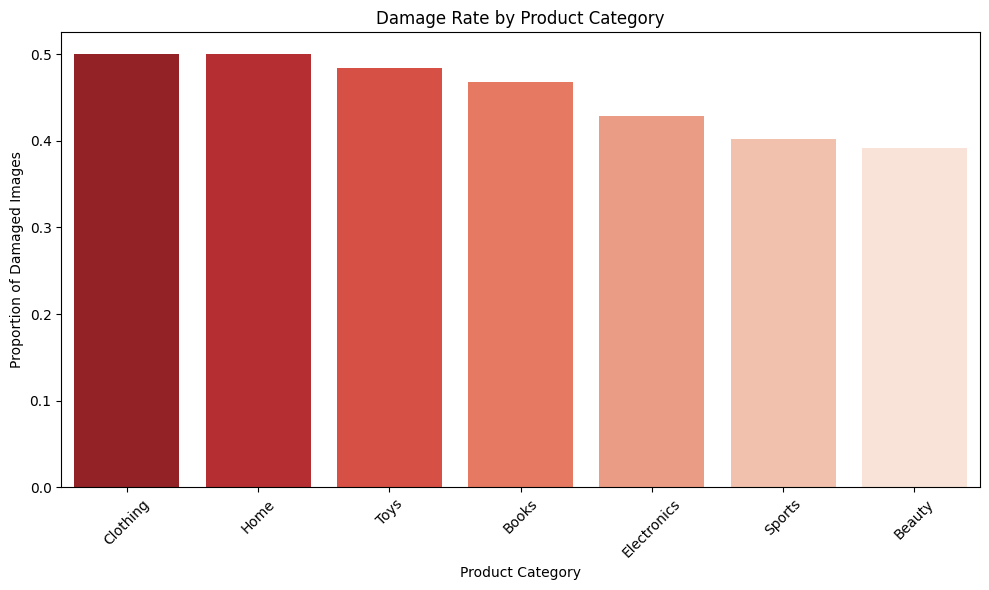

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the updated metadata
df = pd.read_csv("/content/package_metadata.csv")

# Count damaged vs intact by category
category_counts = df.groupby(['category', 'label']).size().unstack().fillna(0)

# Plot damage rates
category_counts['damage_rate'] = category_counts['damaged'] / (category_counts['damaged'] + category_counts['intact'])

# Sort by most damage-prone
category_counts = category_counts.sort_values(by='damage_rate', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=category_counts.reset_index(), x='category', y='damage_rate', palette='Reds_r')
plt.title("Damage Rate by Product Category")
plt.ylabel("Proportion of Damaged Images")
plt.xlabel("Product Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
